# evaluation.ipynb - part 1: setup environment

In [3]:


import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

# set device to gpu if available else cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)

# define your val/test transforms (no augmentation)
val_test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # imagenet mean std if using pretrained
                         std=[0.229, 0.224, 0.225])
])

# assuming you have a custom Dataset class, or use ImageFolder
from torchvision.datasets import ImageFolder

# path to test dataset folder
test_data_path = './eye_dataset/final/test'

# create test dataset and dataloader
test_dataset = ImageFolder(root=test_data_path, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"loaded {len(test_dataset)} test images belonging to {len(test_dataset.classes)} classes")
print("classes:", test_dataset.classes)


using device: cuda
loaded 277 test images belonging to 25 classes
classes: ['barella', 'berkhamp', 'cruyff', 'cubarsi', 'cucurella', 'depaul', 'drogba', 'dumfries', 'etoo', 'gullit', 'ibrahimovic', 'kaka', 'mane', 'mbappe', 'messi', 'neymar', 'nunomendes', 'pedri', 'pele', 'pogba', 'puskas', 'raphina', 'ronaldo', 'salah', 'yamal']


# Training

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
batch_size = 32
num_epochs = 15
learning_rate = 1e-4
num_classes = 25  # your player count

# transforms
train_transform = transforms.Compose([
    transforms.Resize((128, 256)),  # wider image, adjust as needed
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder('./eye_dataset/final/train', transform=train_transform)
val_dataset = datasets.ImageFolder('./eye_dataset/final/val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# model - use pretrained resnet18
model = models.resnet18(pretrained=True)

# replace final fc layer
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

# save model
torch.save(model.state_dict(), 'eye_classifier_resnet18.pth')


/mnt/ExtraData/Github/365DaysOfData/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/nexus/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.3MB/s]


Epoch [1/15] Train Loss: 2.7512 Acc: 0.2508 Val Loss: 1.9748 Acc: 0.5081
Epoch [2/15] Train Loss: 1.0668 Acc: 0.8453 Val Loss: 1.5242 Acc: 0.6371
Epoch [3/15] Train Loss: 0.4096 Acc: 0.9783 Val Loss: 1.3508 Acc: 0.6815
Epoch [4/15] Train Loss: 0.1663 Acc: 0.9983 Val Loss: 1.2334 Acc: 0.6935
Epoch [5/15] Train Loss: 0.0855 Acc: 0.9992 Val Loss: 1.1718 Acc: 0.7177
Epoch [6/15] Train Loss: 0.0518 Acc: 0.9992 Val Loss: 1.1397 Acc: 0.7298
Epoch [7/15] Train Loss: 0.0384 Acc: 0.9983 Val Loss: 1.1250 Acc: 0.7258
Epoch [8/15] Train Loss: 0.0273 Acc: 0.9983 Val Loss: 1.0961 Acc: 0.7419
Epoch [9/15] Train Loss: 0.0228 Acc: 0.9992 Val Loss: 1.0803 Acc: 0.7460
Epoch [10/15] Train Loss: 0.0203 Acc: 0.9983 Val Loss: 1.0819 Acc: 0.7339
Epoch [11/15] Train Loss: 0.0144 Acc: 0.9992 Val Loss: 1.0590 Acc: 0.7298
Epoch [12/15] Train Loss: 0.0130 Acc: 0.9992 Val Loss: 1.0448 Acc: 0.7419
Epoch [13/15] Train Loss: 0.0121 Acc: 0.9983 Val Loss: 1.0492 Acc: 0.7500
Epoch [14/15] Train Loss: 0.0112 Acc: 0.9983 Va

/tmp/ipykernel_90113/112505627.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('eye_classifier_resnet18.pth'))


Test Accuracy: 0.7148


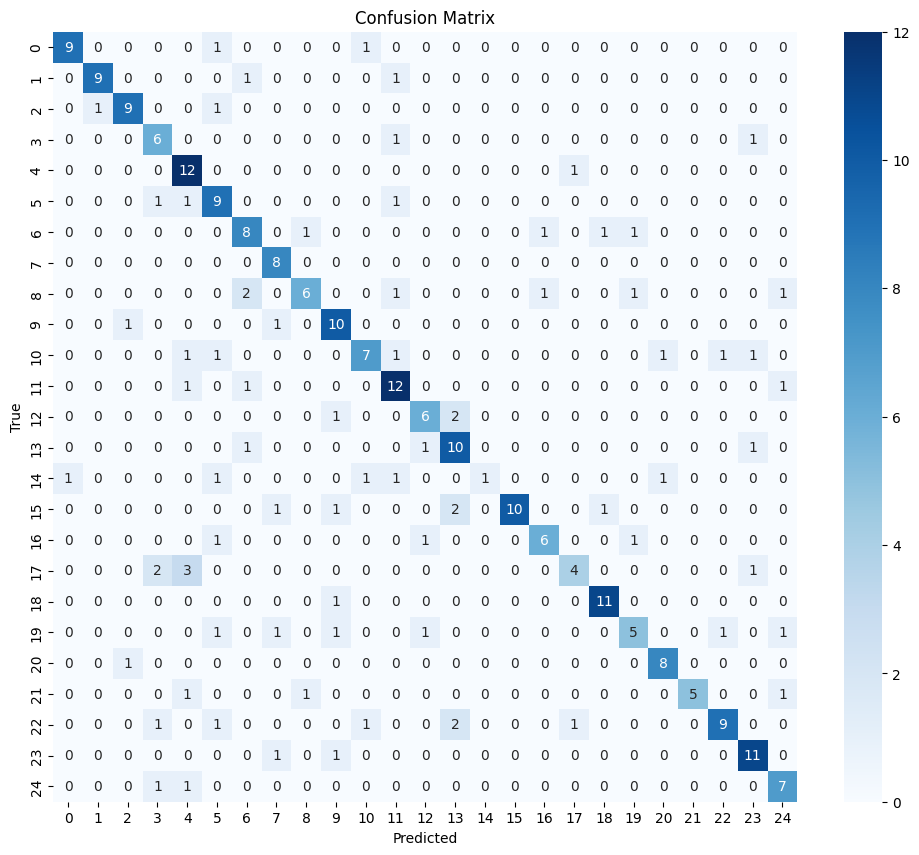

              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.90      0.82      0.86        11
           2       0.82      0.82      0.82        11
           3       0.55      0.75      0.63         8
           4       0.60      0.92      0.73        13
           5       0.56      0.75      0.64        12
           6       0.62      0.67      0.64        12
           7       0.67      1.00      0.80         8
           8       0.75      0.50      0.60        12
           9       0.67      0.83      0.74        12
          10       0.70      0.54      0.61        13
          11       0.67      0.80      0.73        15
          12       0.67      0.67      0.67         9
          13       0.62      0.77      0.69        13
          14       1.00      0.17      0.29         6
          15       1.00      0.67      0.80        15
          16       0.75      0.67      0.71         9
          17       0.67    

In [7]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 25

# same transform as validation
test_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder('./eye_dataset/final/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# load model architecture
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('eye_classifier_resnet18.pth'))
model = model.to(device)
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = correct / total
print(f"Test Accuracy: {acc:.4f}")

# optional: confusion matrix & classification report
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds))


In [11]:
device = torch.device('cpu')
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/tmp/ipykernel_90113/615208015.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('eye_classifier_resnet18.pth', map_location=device))


Correct prediction class distribution:
barella: 9
berkhamp: 9
cruyff: 9
cubarsi: 6
cucurella: 12
depaul: 9
drogba: 8
dumfries: 8
etoo: 6
gullit: 10
ibrahimovic: 7
kaka: 12
mane: 6
mbappe: 10
messi: 1
neymar: 10
nunomendes: 6
pedri: 4
pele: 11
pogba: 5
puskas: 8
raphina: 5
ronaldo: 9
salah: 11
yamal: 7


ValueError: num must be an integer with 1 <= num <= 24, not 25

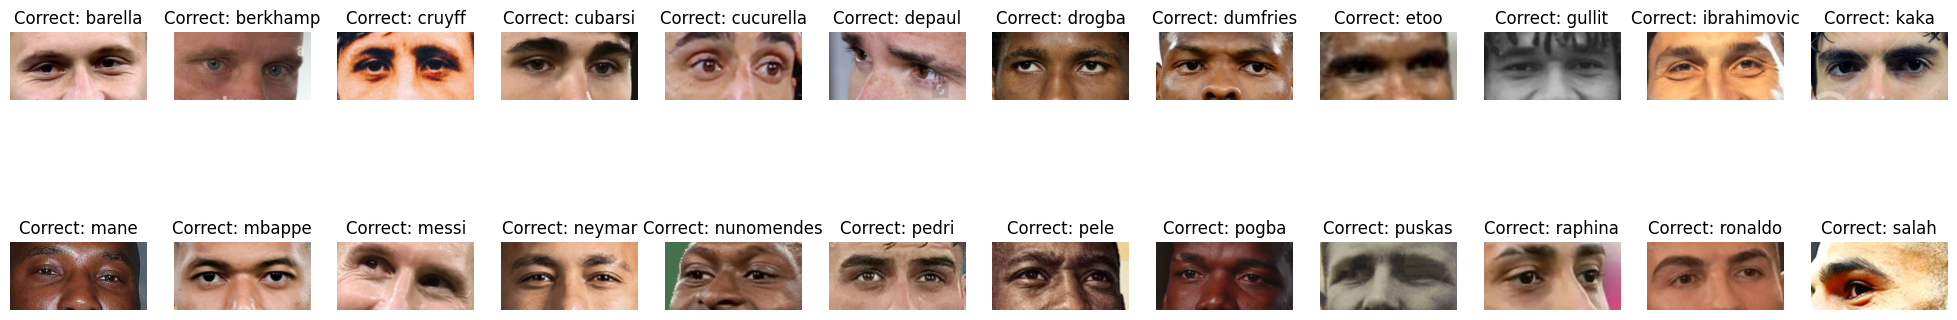

In [54]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# setup dataset & loader (use your test data path)
test_transform = transforms.Compose([
    transforms.Resize((128, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_dataset = ImageFolder('./eye_dataset/final/test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# load your trained model (adjust path)
from torchvision import models
from collections import Counter
import torch.nn as nn

num_classes = 25  # or use your variable if already defined

model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('eye_classifier_resnet18.pth', map_location=device))
model = model.to(device)
model.eval()
# If only "barella" (or any single class) is showing in correct predictions,
# it's likely that your correct_samples list contains mostly or only samples from that class.
# This can happen if:
# - The model is overfitting to that class.
# - The test set is imbalanced.
# - The plotting code only shows the first N correct samples, and those happen to be from "barella".

# To check, let's print the class distribution in correct_samples:

correct_labels = [label.item() for _, label in correct_samples]
label_counts = Counter(correct_labels)
print("Correct prediction class distribution:")
for idx, count in label_counts.items():
    print(f"{class_names[idx]}: {count}")

# To visualize a more diverse set, you can sample one correct prediction per class:
plt.figure(figsize=(25, 5))
shown = 0
shown_classes = set()
for img, label in correct_samples:
    if label.item() not in shown_classes:
        plt.subplot(2, num_classes//2, shown+1)
        plt.imshow(imshow(img))
        plt.title(f"Correct: {class_names[label]}")
        plt.axis('off')
        shown_classes.add(label.item())
        shown += 1
    if shown >= num_classes:
        break
plt.show()
class_names = test_dataset.classes

correct_samples = []
wrong_samples = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        # Move to CPU before appending to lists to free GPU memory
        images_cpu = images.cpu()
        labels_cpu = labels.cpu()
        preds_cpu = preds.cpu()
        for i in range(len(labels_cpu)):
            if preds_cpu[i] == labels_cpu[i]:
                correct_samples.append((images_cpu[i], labels_cpu[i]))
            else:
                wrong_samples.append((images_cpu[i], labels_cpu[i], preds_cpu[i]))
        # Only delete GPU tensors, no need to call empty_cache
        del images, labels, outputs, preds

# helper to unnormalize & convert tensor to numpy image for plt
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# plot some correct predictions
plt.figure(figsize=(25,5))
for i in range(16):
    img, label = correct_samples[i]
    plt.subplot(2, 16, i+1)
    plt.imshow(imshow(img))
    plt.title(f"Correct: {class_names[label]}")
    plt.axis('off')

# plot some wrong predictions
for i in range(8):
    img, label, pred = wrong_samples[i]
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(imshow(img))
    plt.title(f"True: {class_names[label]}\nPred: {class_names[pred]}")
    plt.axis('off')
plt.show()
